## INF2178 - Final Assignment
##### Tiancheng Sheng &ensp; | &ensp; 1007429819 &ensp; | &ensp; tc.sheng@mail.utoronto.ca

In [43]:
import numpy as np
import pandas as pd
import pingouin as pg
from scipy import stats

import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower 
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# for back elimination of linear regression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs  

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

### 1. Import Data

In [2]:
df = pd.read_csv("diabetes.csv")
print(df.shape)
df.head()

(768, 9)


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# Save the description of the dataset
import io

buffer = io.StringIO()
df.info(buf=buffer)
s = buffer.getvalue()

with open("df_info.txt", "w", encoding="utf-8") as f:  
    f.write(s)

### 2. Exploratory Data Analysis

In [5]:
features = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
            "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

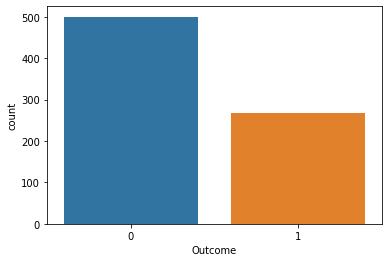

In [6]:
# Plot of the distributions of "Outcome"
sns.countplot(data=df, x="Outcome")
plt.savefig("Outcome_distribution.png", facecolor='white')
plt.show()

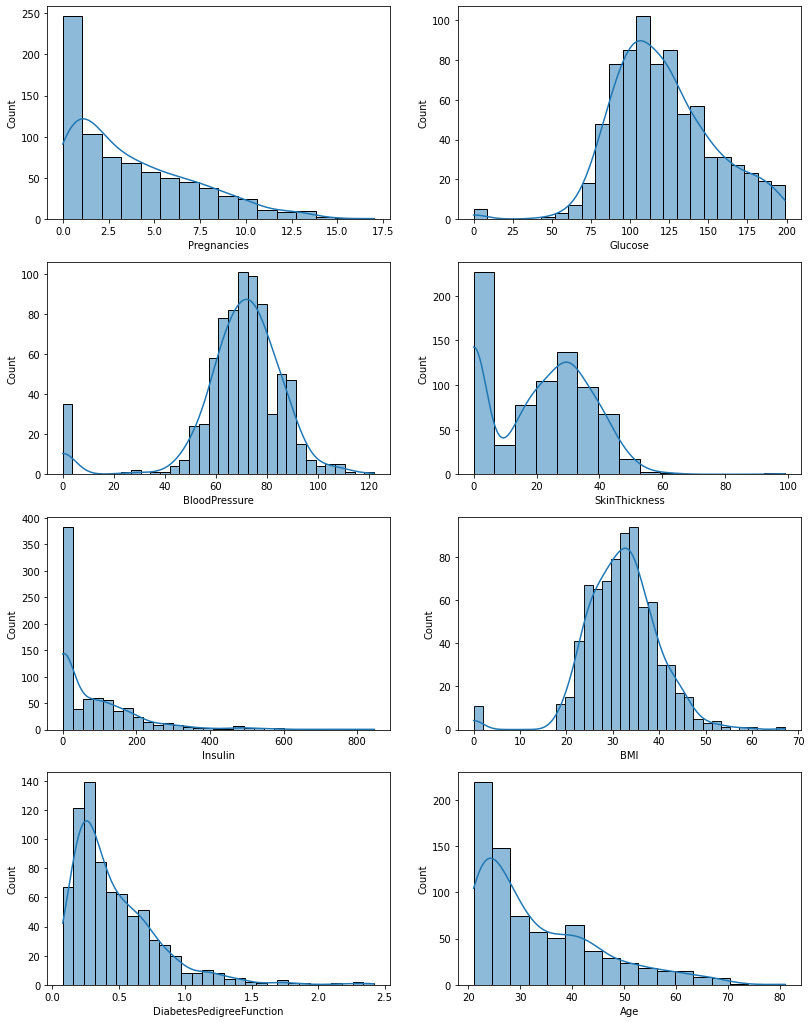

In [7]:
# Let's plot the distributions of the features
plt.figure(figsize=(13.5,18))
for i in range(len(features)):
    plt.subplot(4, 2, i+1)
    sns.histplot(data=df, x=features[i], kde=True)
plt.savefig("Features_distribution.png", facecolor='white', pad_inches=0)

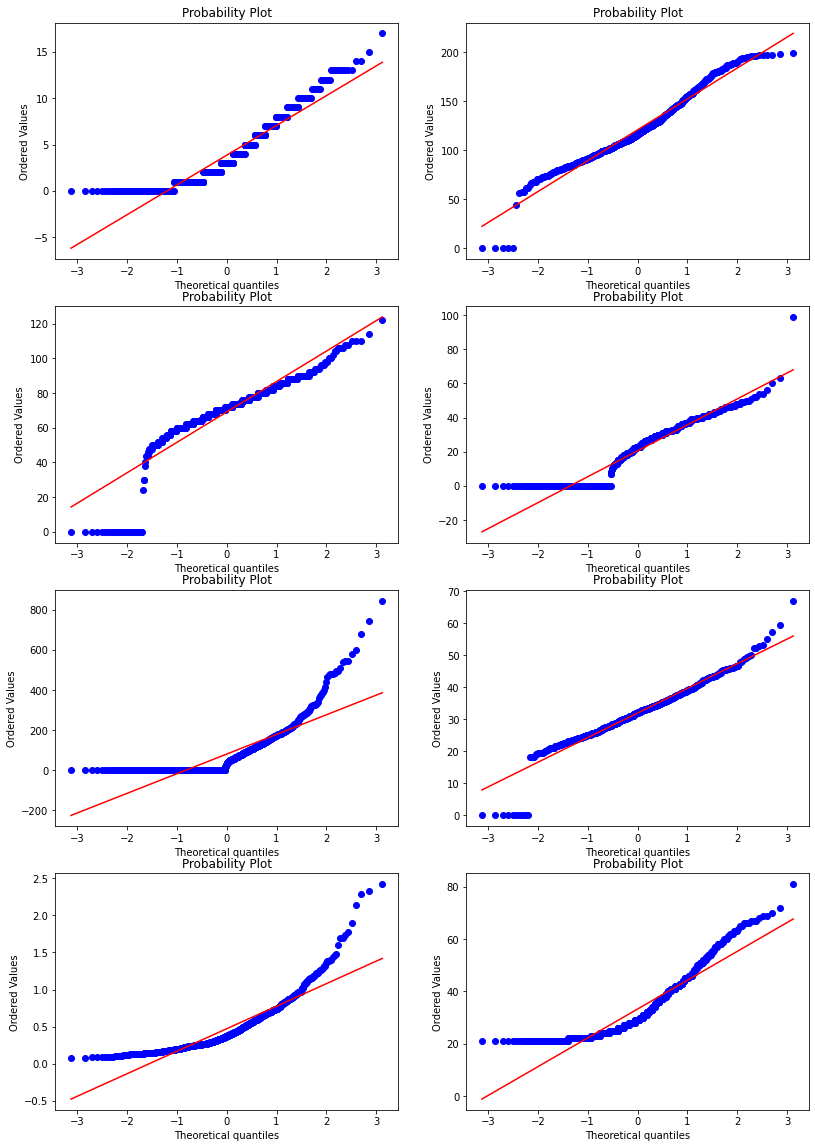

In [8]:
# Let's plot the q-q plots of the features
plt.figure(figsize=(13.5,20))
for i in range(len(features)):
    plt.subplot(4, 2, i+1)
    stats.probplot(df[features[i]], plot=plt)
plt.show()
    #sm.qqplot(df[features[i]].values)
    #sns.histplot(data=df, x=features[i], kde=True)

In [9]:
# Shapiro test over Glucose, BloodPressure, SkinThickness, BMI, and DiabetesPedigreeFunction
var_list = ["Glucose", "BloodPressure", "SkinThickness", "BMI", "DiabetesPedigreeFunction"]
shapiro_dict = {
    "Glucose" : [],
    "BloodPressure" : [],
    "SkinThickness" : [],
    "BMI" : [],
    "DiabetesPedigreeFunction" : [],
}

for var in var_list:
    shapiro = stats.shapiro(df[var])
    shapiro_dict[var].append(shapiro[0])
    shapiro_dict[var].append(shapiro[1])

shapiro_df = pd.DataFrame.from_dict(shapiro_dict, orient='index', columns = ["statistics", "p-value"])
pd.options.display.float_format = '{:,.6f}'.format
display(shapiro_df)                         

statistics  p-value
Glucose                     0.970104 0.000000
BloodPressure               0.818921 0.000000
SkinThickness               0.904627 0.000000
BMI                         0.949989 0.000000
DiabetesPedigreeFunction    0.836519 0.000000

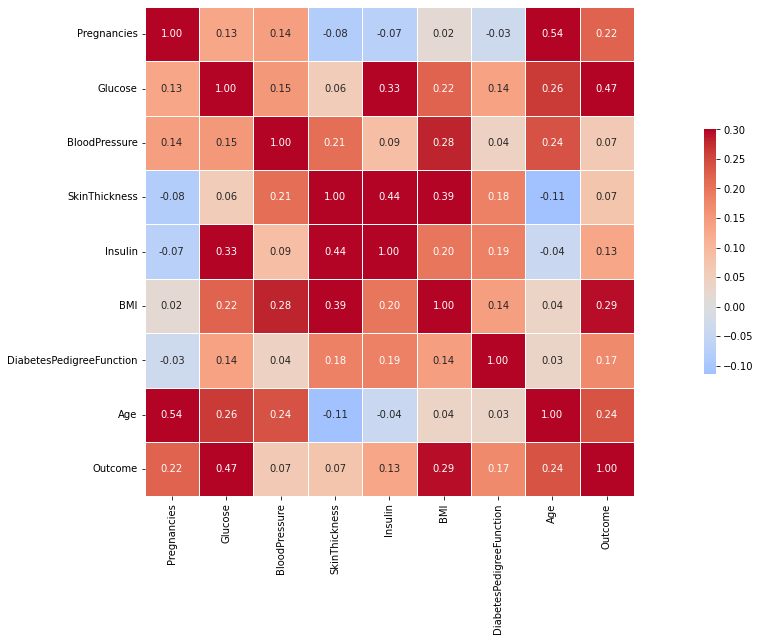

In [10]:
# Create correlation plot 
corr = df.corr()
g = sns.heatmap(corr, 
                vmax=.3, center=0,
                square=True, linewidths=.5, 
                cbar_kws={"shrink": .5}, annot=True, 
                fmt='.2f', cmap='coolwarm')
g.figure.set_size_inches(25,9)
plt.show()

### 3. Data Cleaning & Categorizing

#### 3.1 Data Cleaning

In [11]:
# Check if there is null value in the dataset
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [12]:
# Check the zero values in each columns
df[df == 0].count(axis=0)

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [13]:
# The zeros in columns "Pregnancies" and "Outcomes" represent negative
# So we replace the zeros in all the other columns into null value 
# and then drop the rows with null values
df[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]] = df[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]].replace(0, np.NaN)
df = df.dropna(how="any")
df[df == 0].count(axis=0)

Pregnancies                  56
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     262
dtype: int64

In [14]:
pd.options.display.float_format = '{:,.4f}'.format
display(df.describe())

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin      BMI  \
count     392.0000 392.0000       392.0000       392.0000 392.0000 392.0000   
mean        3.3010 122.6276        70.6633        29.1454 156.0561  33.0862   
std         3.2114  30.8608        12.4961        10.5164 118.8417   7.0277   
min         0.0000  56.0000        24.0000         7.0000  14.0000  18.2000   
25%         1.0000  99.0000        62.0000        21.0000  76.7500  28.4000   
50%         2.0000 119.0000        70.0000        29.0000 125.5000  33.2000   
75%         5.0000 143.0000        78.0000        37.0000 190.0000  37.1000   
max        17.0000 198.0000       110.0000        63.0000 846.0000  67.1000   

       DiabetesPedigreeFunction      Age  Outcome  
count                  392.0000 392.0000 392.0000  
mean                     0.5230  30.8648   0.3316  
std                      0.3455  10.2008   0.4714  
min                      0.0850  21.0000   0.0000  
25%                      0.2698  23.0000   0.0000  
50%                      0.4495  27.0000   0.0000  
75%                      0.6870  36.0000   1.0000  
max                      2.4200  81.0000   1.0000

#### 3.2 Categorizing

For further analysis, I will categorize the columns: "BloodPressure", "Insulin", "BMI", and "Age".
- **BloodPressure**: 
    - low: < 60
    - normal: 60 - 80
    - high: > 80
- **Insulin**:
    - low: < 20
    - mid: 20 - 80
    - high: > 80
- **BMI**: 
    - underweight: < 18.5
    - normal: 18.5 - 24.9
    - overweight: > 24.9
- **Age**:
    - youth: 18 - 24
    - adult: 25 - 65
    - senior: > 65

In [15]:
# Categorize the three columns above
df["BloodPressure_cat"] = pd.cut(df.BloodPressure, [1, 60, 80, 140], labels=["low", "normal", "high"])

df["Insulin_cat"] = pd.cut(df.Insulin, [1, 20, 80, 1000], labels=["low", "mid", "high"])

df["BMI_cat"] = pd.cut(df.BMI, [1, 18.5, 24.9, 100], labels=["underweight", "normal", "overweight"])

df["Age_cat"] = pd.cut(df.Age, [18, 25, 60, 100], labels=["youth", "adult", "senior"])

df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  \
3             1  89.0000        66.0000        23.0000  94.0000 28.1000   
4             0 137.0000        40.0000        35.0000 168.0000 43.1000   
6             3  78.0000        50.0000        32.0000  88.0000 31.0000   
8             2 197.0000        70.0000        45.0000 543.0000 30.5000   
13            1 189.0000        60.0000        23.0000 846.0000 30.1000   

    DiabetesPedigreeFunction  Age  Outcome BloodPressure_cat Insulin_cat  \
3                     0.1670   21        0            normal        high   
4                     2.2880   33        1               low        high   
6                     0.2480   26        1               low        high   
8                     0.1580   53        1            normal        high   
13                    0.3980   59        1               low        high   

       BMI_cat Age_cat  
3   overweight   youth  
4   overweight   adult  
6   overweight   adult  
8   overweight   adult  
13  overweight   adult

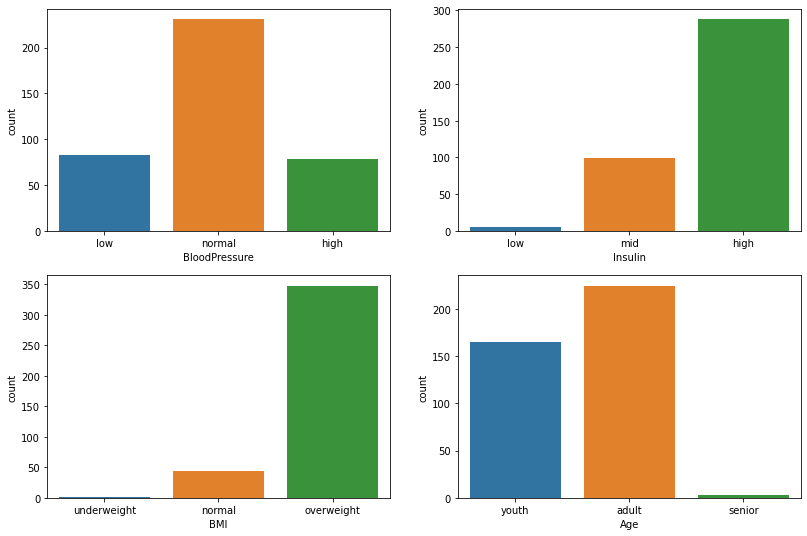

In [16]:
# Plot the distributions of the categorized data
plt.figure(figsize=(13.5, 9))
for i, var in enumerate(["BloodPressure_cat", "Insulin_cat", "BMI_cat", "Age_cat"]):
    plt.subplot(2, 2, i+1)
    sns.countplot(data=df, x=var)
    plt.xlabel(var.split("_")[0])
plt.show()

### 4. Power Analysis

In [22]:
size = TTestIndPower().solve_power(effect_size=0.8, alpha=0.05, power=0.8, nobs1=None, ratio=1.0)
print('Minimum Sample Size: {:.6f}'.format(size))

Minimum Sample Size: 25.524573


#### 4.1 Sample Sizes ~ Power

In [56]:
effect_sizes = [0.2, 0.4, 0.6, 0.8]
sample_sizes = np.array(range(5, 100))
alpha = 0.05
power = 0.8

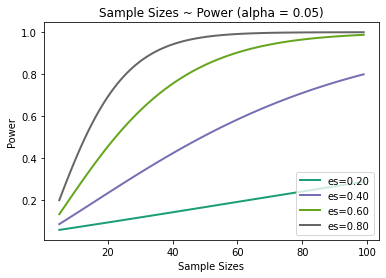

In [62]:
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.xlabel("Sample Sizes")
plt.ylabel("Power")
plt.title("Sample Sizes ~ Power (alpha = 0.05)")
plt.show()

#### 4.2 Effect Sizes ~ Power

In [ ]:
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

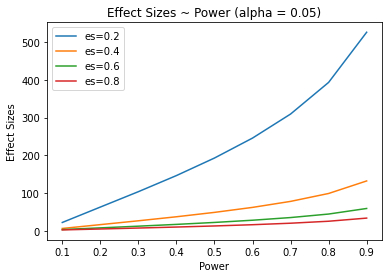

In [61]:
results = []
powers = [i/10 for i in range(1,10)]
plt.figure()

for es in effect_sizes:
    temp = []
    for power in powers:
        temp.append(TTestIndPower().solve_power(effect_size=es, alpha=0.05, power=power))
    sns.lineplot(x=powers, y=temp, label="es="+str(es))

plt.ylabel("Effect Sizes")
plt.xlabel("Power")
plt.title("Effect Sizes ~ Power (alpha = 0.05)")
plt.show()

#### 4.3 Sample Sizes ~ Effect Sizes

In [33]:
def power_analysis_func(row):
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=row["Effect Size"], alpha=alpha, power=power, nobs1=None, ratio=1.0)

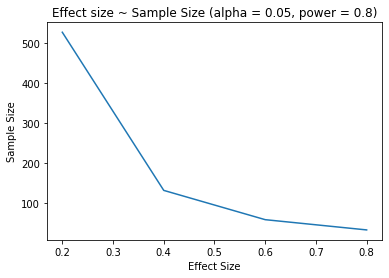

In [59]:
power_analysis_df = pd.DataFrame({"Effect Size": effect_sizes, "Alpha": alpha, "Power": power})
power_analysis_df["Sample Size"] = power_analysis_df.apply(power_analysis_func, axis=1)

ax = sns.lineplot(data=power_analysis_df, x="Effect Size", y="Sample Size")
ax.set_title("Effect size ~ Sample Size (alpha = 0.05, power = 0.8)")
plt.show()

### 5. ANOVA Modelling

#### 5.1 ANOVA

##### Research Question 1: Whether the column of glucose who was influenced by people's **blood pressure**
${H_0}$: There is no difference in glucose between types of blood pressure <br>
${H_1}$: There is a difference in glucose between types of blood pressure

Source           SS   DF         MS      F  p-unc    np2
0  BloodPressure_cat  14,389.6005    2 7,194.8003 7.8179 0.0005 0.0386
1             Within 357,994.0219  389   920.2931    NaN    NaN    NaN

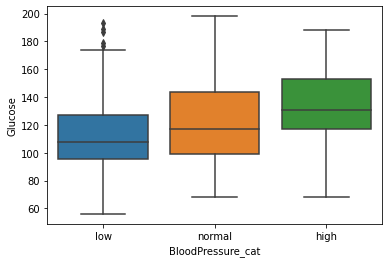

In [69]:
# BloodPressure 
glucose_bp = pg.anova(data=df, dv="Glucose", between="BloodPressure_cat", detailed=True)
display(glucose_bp)

# Boxplot the Glucose againest BloodPressure
print("\n")
plt.figure()
sns.boxplot(x="BloodPressure_cat", y="Glucose", data=df)
plt.show()

In [51]:
# Post-hoc tukey test
pt_glucose_bp = pg.pairwise_tukey(dv="Glucose", between="BloodPressure_cat", effsize="cohen", data=df)
pt_glucose_bp

A       B  mean(A)  mean(B)     diff     se       T  p-tukey   cohen
0     low  normal 113.7229 122.4502  -8.7273 3.8822 -2.2480   0.0646 -0.2877
1     low    high 113.7229 132.6282 -18.9053 4.7840 -3.9518   0.0003 -0.6232
2  normal    high 122.4502 132.6282 -10.1780 3.9727 -2.5620   0.0290 -0.3355

In [46]:
# Confidence Intervals
mod_glucose_bp = ols("Glucose ~ BloodPressure_cat", data=df).fit()
pair_t_glucose_bp = mod_glucose_bp.t_test_pairwise("BloodPressure_cat")
display(pair_t_glucose_bp.result_frame)

coef  std err      t  P>|t|  Conf. Int. Low  Conf. Int. Upp.  \
normal-low   8.7273   3.8822 2.2480 0.0251          1.0945          16.3601   
high-low    18.9053   4.7840 3.9518 0.0001          9.4996          28.3110   
high-normal 10.1780   3.9727 2.5620 0.0108          2.3673          17.9887   

             pvalue-hs  reject-hs  
normal-low      0.0251       True  
high-low        0.0003       True  
high-normal     0.0215       True

##### Research Question 2: Whether the column of glucose who was influenced by people's **Insulin**
${H_0}$: There is no difference in glucose between types of Insulin change <br>
${H_1}$: There is a difference in glucose between types of Insulin change

Source           SS   DF          MS       F  p-unc    np2
0  Insulin_cat  88,746.4767    2 44,373.2384 60.8566 0.0000 0.2383
1       Within 283,637.1457  389    729.1443     NaN    NaN    NaN

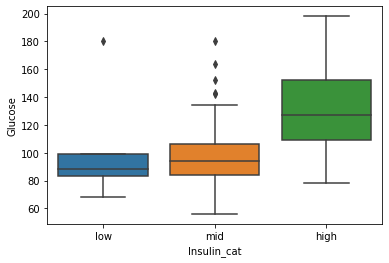

In [52]:
# Insulin 
glucose_in = pg.anova(data=df, dv="Glucose", between="Insulin_cat", detailed=True)
display(glucose_in)

# Boxplot the Glucose againest BloodPressure
print("\n")
plt.figure()
sns.boxplot(x="Insulin_cat", y="Glucose", data=df)
plt.show()

In [53]:
# Post-hoc tukey test
pt_glucose_in = pg.pairwise_tukey(dv="Glucose", between="Insulin_cat", effsize="cohen", data=df)
pt_glucose_in

A     B  mean(A)  mean(B)     diff      se        T  p-tukey   cohen
0  low   mid 103.6000  97.3131   6.2869 12.3772   0.5079   0.8675  0.2328
1  low  high 103.6000 131.6597 -28.0597 12.1803  -2.3037   0.0565 -1.0391
2  mid  high  97.3131 131.6597 -34.3466  3.1459 -10.9178   0.0000 -1.2720

In [49]:
# Confidence Intervals
mod_glucose_in = ols("Glucose ~ Insulin_cat", data=df).fit()
pair_t_glucose_in = mod_glucose_in.t_test_pairwise("Insulin_cat")
display(pair_t_glucose_in.result_frame)

coef  std err       t  P>|t|  Conf. Int. Low  Conf. Int. Upp.  \
mid-low  -6.2869  12.3772 -0.5079 0.6118        -30.6214          18.0476   
high-low 28.0597  12.1803  2.3037 0.0218          4.1122          52.0073   
high-mid 34.3466   3.1459 10.9178 0.0000         28.1614          40.5317   

          pvalue-hs  reject-hs  
mid-low      0.6118      False  
high-low     0.0431       True  
high-mid     0.0000       True

##### Research Question 3: Whether the column of glucose who was influenced by people's **BMI**
${H_0}$: There is no difference in glucose between types of BMI <br>
${H_1}$: There is a difference in glucose between types of BMI

Source           SS   DF         MS      F  p-unc    np2
0  BMI_cat  13,260.6174    2 6,630.3087 7.1819 0.0009 0.0356
1   Within 359,123.0050  389   923.1954    NaN    NaN    NaN

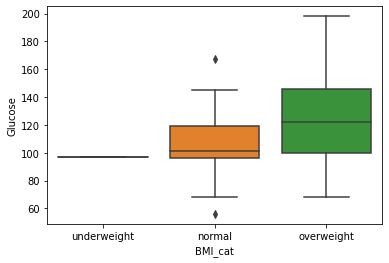

In [54]:
glucose_bmi = pg.anova(data=df, dv="Glucose", between="BMI_cat", detailed=True)
display(glucose_bmi)

# Boxplot the Glucose againest BMI
print("\n")
plt.figure()
sns.boxplot(x="BMI_cat", y="Glucose", data=df)
plt.show()

In [55]:
# Post-hoc tukey test
pt_glucose_bmi = pg.pairwise_tukey(dv="Glucose", between="BMI_cat", effsize="cohen", data=df)
pt_glucose_bmi

A           B  mean(A)  mean(B)     diff      se       T  \
0  underweight      normal  97.0000 106.7500  -9.7500 30.7275 -0.3173   
1  underweight  overweight  97.0000 124.7147 -27.7147 30.4279 -0.9108   
2       normal  overweight 106.7500 124.7147 -17.9647  4.8623 -3.6947   

   p-tukey   cohen  
0   0.9460 -0.3209  
1   0.6338 -0.9121  
2   0.0007 -0.5913

In [50]:
# Confidence Intervals
mod_glucose_bmi = ols("Glucose ~ BMI_cat", data=df).fit()
pair_t_glucose_bmi = mod_glucose_bmi.t_test_pairwise("BMI_cat")
display(pair_t_glucose_bmi.result_frame)

coef  std err      t  P>|t|  Conf. Int. Low  \
normal-underweight      9.7500  30.7275 0.3173 0.7512        -50.6627   
overweight-underweight 27.7147  30.4279 0.9108 0.3629        -32.1090   
overweight-normal      17.9647   4.8623 3.6947 0.0003          8.4050   

                        Conf. Int. Upp.  pvalue-hs  reject-hs  
normal-underweight              70.1627     0.7512      False  
overweight-underweight          87.5384     0.5942      False  
overweight-normal               27.5244     0.0008       True

##### Research Question 4: Whether the column of glucose who was influenced by people's **age**
${H_0}$: There is no difference in glucose between ages <br>
${H_1}$: There is a difference in glucose between tages

Source           SS   DF          MS       F  p-unc    np2
0  Age_cat  33,965.0345    2 16,982.5172 19.5208 0.0000 0.0912
1   Within 338,418.5880  389    869.9707     NaN    NaN    NaN

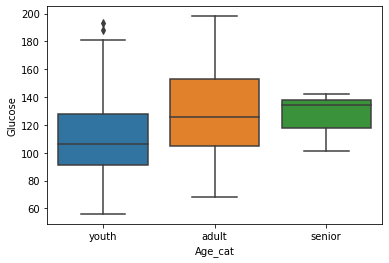

In [56]:
glucose_age = pg.anova(data=df, dv="Glucose", between="Age_cat", detailed=True)
display(glucose_age)

# Boxplot the Glucose againest Age
print("\n")
plt.figure()
sns.boxplot(x="Age_cat", y="Glucose", data=df)
plt.show()

In [57]:
# Post-hoc tukey test
pt_glucose_age = pg.pairwise_tukey(dv="Glucose", between="Age_cat", effsize="cohen", data=df)
pt_glucose_age

A       B  mean(A)  mean(B)     diff      se       T  p-tukey   cohen
0  youth   adult 111.7212 130.6205 -18.8993  3.0259 -6.2458   0.0000 -0.6408
1  youth  senior 111.7212 125.6667 -13.9455 17.1832 -0.8116   0.6961 -0.4728
2  adult  senior 130.6205 125.6667   4.9539 17.1428  0.2890   0.9550  0.1680

In [51]:
# Confidence Intervals
mod_glucose_age = ols("Glucose ~ Age_cat", data=df).fit()
pair_t_glucose_age = mod_glucose_age.t_test_pairwise("Age_cat")
display(pair_t_glucose_age.result_frame)

coef  std err       t  P>|t|  Conf. Int. Low  Conf. Int. Upp.  \
adult-youth  18.8993   3.0259  6.2458 0.0000         12.9501          24.8486   
senior-youth 13.9455  17.1832  0.8116 0.4175        -19.8381          47.7290   
senior-adult -4.9539  17.1428 -0.2890 0.7728        -38.6579          28.7502   

              pvalue-hs  reject-hs  
adult-youth      0.0000       True  
senior-youth     0.6607      False  
senior-adult     0.7728      False

#### 5.2 T-tests

In [59]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
3             1     89.0           66.0           23.0     94.0  28.1   
4             0    137.0           40.0           35.0    168.0  43.1   
6             3     78.0           50.0           32.0     88.0  31.0   
8             2    197.0           70.0           45.0    543.0  30.5   
13            1    189.0           60.0           23.0    846.0  30.1   

    DiabetesPedigreeFunction  Age  Outcome BloodPressure_cat Insulin_cat  \
3                      0.167   21        0            normal        high   
4                      2.288   33        1               low        high   
6                      0.248   26        1               low        high   
8                      0.158   53        1            normal        high   
13                     0.398   59        1               low        high   

       BMI_cat Age_cat  
3   overweight   youth  
4   overweight   adult  
6   overweight   adult  
8   overweight   adult  
13  overweight   adult

In [39]:
def run_t_test(df, var, name, measure_list):
    result_dict = {}
    
    for i, j in combinations(measure_list, 2):
        row = str(i) + " vs " + str(j)
        sample_1 = df[df[var] == i].Glucose
        sample_2 = df[df[var] == j].Glucose
        t_stat, p_val = stats.ttest_ind(sample_1, sample_2, equal_var = False)
        # if row not in result_dict:
        #     result_dict[row] = []
        result_dict[row] = [t_stat, p_val]
        
    result_df = pd.DataFrame.from_dict(result_dict, orient="index", columns=["t-statistics (glucose)", "p-value"])
    result_df.index.names = [name]
    display(result_df)

In [40]:
# Test 1: BloodPressure
run_t_test(df, "BloodPressure_cat", "blood pressure", ["low", "normal", "high"])

t-statistics (glucose)  p-value
blood pressure                                 
low vs normal                  -2.3423   0.0204
low vs high                    -4.1391   0.0001
normal vs high                 -2.5895   0.0106

In [ ]:
pg.ttest(df[variable], nodiabetes[variable], correction=False)

In [41]:
# Test 2: Insulin
run_t_test(df, "Insulin_cat", "Insulin", ["low", "mid", "high"])

t-statistics (glucose)  p-value
Insulin                                     
low vs mid                   0.3167   0.7670
low vs high                 -1.4163   0.2286
mid vs high                -12.8259   0.0000

In [121]:
# Test 3: BMI
run_t_test(df, "BMI_cat", "BMI", ["underweight", "normal", "overweight"])

t-statistics (glucose)  p-value
BMI                                                       
underweight vs normal                         NaN      NaN
underweight vs overweight                     NaN      NaN
normal vs overweight                      -4.9080   0.0000

In [122]:
# Test 4: Age
run_t_test(df, "Age_cat", "Age", ["youth", "adult", "senior"])

t-statistics (glucose)  p-value
Age                                             
youth vs adult                  -6.3446   0.0000
youth vs senior                 -1.0954   0.3821
adult vs senior                  0.3896   0.7327

#### 5.3 Muitiple Linear Regression

${X = ["Pregnancies", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]}$ <br>
${Y = Glucose}$

In [81]:
variables = ["Pregnancies", "BloodPressure", "SkinThickness", 
             "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

In [96]:
# Some processing on the dataset
X_n = df[variables]
y = df.Glucose
X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(y_train.shape)

(313, 7)
(313,)


In [97]:
X_train.head()

Pregnancies  BloodPressure  SkinThickness  Insulin     BMI  \
427            1        64.0000        30.0000 180.0000 34.1000   
498            7        70.0000        33.0000 145.0000 25.1000   
575            1        44.0000        47.0000  63.0000 35.5000   
379            0       100.0000        39.0000  72.0000 43.4000   
122            2        74.0000        30.0000 100.0000 33.6000   

     DiabetesPedigreeFunction  Age  
427                    0.3280   38  
498                    0.1630   55  
575                    0.2800   25  
379                    1.0210   35  
122                    0.4040   23

In [146]:
# Backward elimination on building multiple linear regression model
model_features = []
best_model_features = []
best_r2 = 0


for i in range(1, len(variables) + 1):
    lr_model = LinearRegression()
    sfs_model = sfs(lr_model, k_features=i, forward=False)
    sfs_model.fit(X_train, y_train)

    model_features.append(list(sfs_model.k_feature_names_))
    
    
for var_list in model_features:
    X_test_var_list = X_test[var_list]
    X_train_var_list = X_train[var_list]
    lr_model = LinearRegression()
    lr_model.fit(X_train_var_list, y_train)
    y_test_pred = lr_model.predict(X_test_var_list)
    curr_r2 = r2_score(y_test.values.reshape(-1, 1), y_test_pred)
    
    if best_r2 < curr_r2:
        best_model_features = var_list
        best_r2 = curr_r2

        
print(best_model_features)

['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [147]:
# Using all the features yields the best performance
# Build the Multi-Linear Regression (MLR) model
X_n_const = sm.add_constant(X_n[best_model_features])
lr_model = sm.OLS(y, X_n_const, missing='drop')
model_result = lr_model.fit()

# Get the R-squared and Adjusted R-squared of the MLR model
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Glucose   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     36.76
Date:                Mon, 28 Mar 2022   Prob (F-statistic):           2.81e-39
Time:                        22:50:15   Log-Likelihood:                -1799.6
No. Observations:                 392   AIC:                             3615.
Df Residuals:                     384   BIC:                             3647.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       60.0300      8.441      7.112      0.000      43.433      76.627
Pregnancies                  0.0738      0.523      0.141      0.888      -0.955       1.102
BloodPressure                0.2134      0.108      1.982      0.048       0.002       0.425
SkinThickness                0.0743      0.158      0.471      0.638      -0.236       0.384
Insulin                      0.1332      0.011     12.293      0.000       0.112       0.155
BMI                          0.1304      0.244      0.535      0.593      -0.349       0.610
DiabetesPedigreeFunction     4.1785      3.624      1.153      0.250      -2.947      11.304
Age                          0.5773      0.172      3.360      0.001       0.240       0.915
==============================================================================
Omnibus:                       23.542   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.110
Skew:                           0.596   Prob(JB):                     2.14e-06
Kurtosis:                       3.422   Cond. No.                     1.46e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [148]:
# Test the linear relationships between each independent varibles
# and the dependent variables
r2_dict = {}

for var in variables:
    lr = LinearRegression()
    X = X_n[var].values.reshape(-1,1)
    lr.fit(X, y)
    r2 = lr.score(X, y)
    r2_dict[var] = r2
    #print('R^2 for {}: {:.6f}'.format(X_n.columns[i], r2))

r2_dict = pd.DataFrame.from_dict(r2_dict, orient="index", columns=["R-squared"])
display(r2_dict)

R-squared
Pregnancies                  0.0393
BloodPressure                0.0441
SkinThickness                0.0395
Insulin                      0.3378
BMI                          0.0439
DiabetesPedigreeFunction     0.0197
Age                          0.1181

In [34]:
# Get the regression metrics
# res = stat()
# res.reg_metric(y=np.array(y), yhat=np.array(reg.predict(X)), resid=np.array(reg.resid))
# res.reg_metric_df

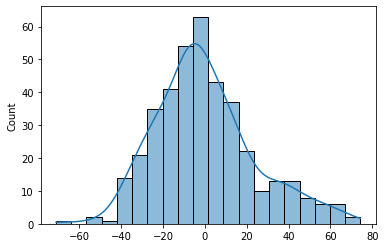

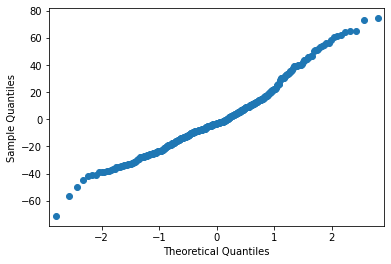

In [90]:
# Get the residual of the MLR model (histogram & Q-Q plot)
residual = model_result.resid
X_n["residual"] = residual

sns.histplot(residual, kde=True)
sm.qqplot(residual)
plt.show()

In [82]:
# Shapiro test
stats.shapiro(model_result.resid)

ShapiroResult(statistic=0.9718645811080933, pvalue=7.053167792037129e-07)

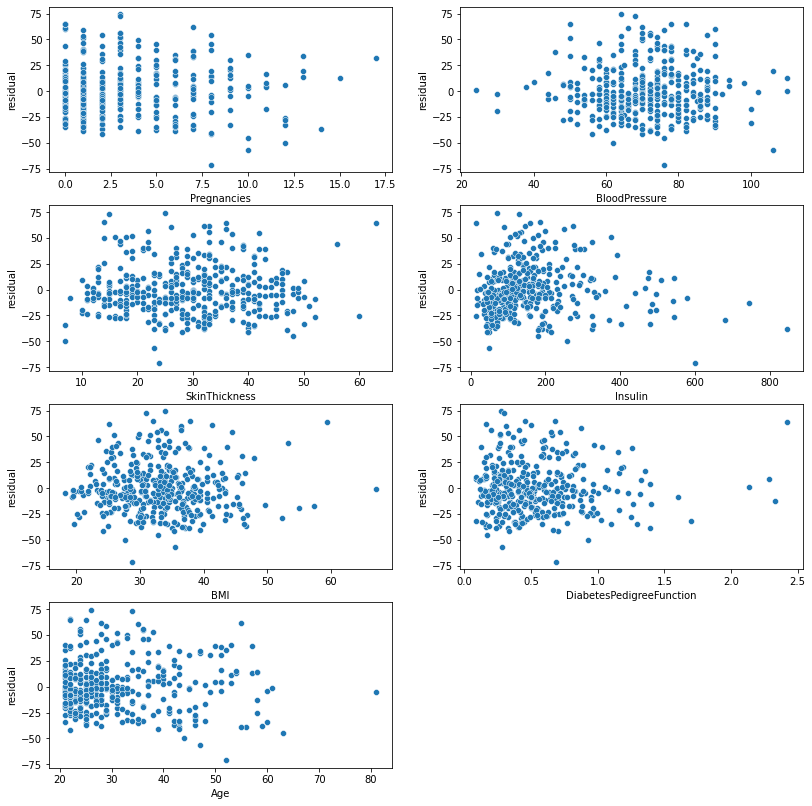

In [91]:
# Plot residual againest variables
plt.figure(figsize=(13.5,14))
for i in range(len(variables)):
    plt.subplot(4, 2, i+1)
    sns.scatterplot(data=X_n, x=variables[i], y="residual")
plt.show()

### 6. ANCOVA Modelling

##### Glucose ~ BMI, Covaraite = Age

In [35]:
bmi_co_age = pg.ancova(data=df, dv="Glucose", between="BMI_cat", covar="Age")
display(bmi_co_age)

Source           SS   DF       F  p-unc    np2
0   BMI_cat   7,897.1766    2  4.7800 0.0089 0.0240
1       Age  38,611.1477    1 46.7413 0.0000 0.1075
2  Residual 320,511.8573  388     NaN    NaN    NaN

##### Glucose ~ Insulin, Covaraite = Age

In [36]:
insulin_co_age = pg.ancova(data=df, dv="Glucose", between="Insulin_cat", covar="Age")
display(insulin_co_age)

Source           SS   DF       F  p-unc    np2
0  Insulin_cat  69,892.5099    2 52.4498 0.0000 0.2128
1          Age  25,120.6217    1 37.7028 0.0000 0.0886
2     Residual 258,516.5240  388     NaN    NaN    NaN

##### Glucose ~ BloodPressure, Covaraite = Age

In [37]:
bp_co_age = pg.ancova(data=df, dv="Glucose", between="BloodPressure_cat", covar="Age")
display(bp_co_age)

Source           SS   DF       F  p-unc    np2
0  BloodPressure_cat   4,870.7994    2  2.9206 0.0551 0.0148
1                Age  34,455.7874    1 41.3208 0.0000 0.0962
2           Residual 323,538.2345  388     NaN    NaN    NaN

##### Glucose ~ BloodPressure, Covaraite = BMI

In [38]:
bp_co_bmi = pg.ancova(data=df, dv="Glucose", between="BloodPressure_cat", covar="BMI")
display(bp_co_bmi)

Source           SS   DF       F  p-unc    np2
0  BloodPressure_cat   7,778.8293    2  4.3333 0.0138 0.0218
1                BMI   9,735.7230    1 10.8467 0.0011 0.0272
2           Residual 348,258.2990  388     NaN    NaN    NaN